In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [60]:
import numpy as np 
import pandas as pd
import pydicom
import albumentations as A



In [2]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from torch.utils.data import DataLoader, Dataset

In [3]:
train_df  = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_label_cordi = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_series_description = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [4]:
#train_label_cordi.info()

In [5]:
#train_series_description.info()

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   study_id                                1975 non-null   int64 
 1   spinal_canal_stenosis_l1_l2             1974 non-null   object
 2   spinal_canal_stenosis_l2_l3             1974 non-null   object
 3   spinal_canal_stenosis_l3_l4             1974 non-null   object
 4   spinal_canal_stenosis_l4_l5             1974 non-null   object
 5   spinal_canal_stenosis_l5_s1             1974 non-null   object
 6   left_neural_foraminal_narrowing_l1_l2   1973 non-null   object
 7   left_neural_foraminal_narrowing_l2_l3   1973 non-null   object
 8   left_neural_foraminal_narrowing_l3_l4   1973 non-null   object
 9   left_neural_foraminal_narrowing_l4_l5   1973 non-null   object
 10  left_neural_foraminal_narrowing_l5_s1   1973 non-null   object
 11  righ

In [7]:
#train_series_description

# Prepare data in dictionary format

In [8]:
train_series_description

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
...,...,...,...
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2


In [9]:
train_label_cordi

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333


In [10]:
train_label_cordi['image_path'] = train_label_cordi.apply(lambda row: f"/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm", axis=1)

In [11]:
train_label_cordi = pd.merge(train_label_cordi, train_series_description, on=['study_id', 'series_id'], how='inner')

In [23]:
train_label_cordi

,study_id,series_id,instance_number,condition,level,x,y,image_path,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm,Sagittal T2/STIR
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm,Sagittal T2/STIR
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm,Sagittal T2/STIR
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm,Sagittal T2/STIR
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4290709089/4237840455/11.dcm,Sagittal T1
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4290709089/4237840455/12.dcm,Sagittal T1
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4290709089/4237840455/12.dcm,Sagittal T1
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4290709089/4237840455/12.dcm,Sagittal T1


In [34]:
train_label_cordi[train_label_cordi['study_id']==74782131]

,study_id,series_id,instance_number,condition,level,x,y,image_path,series_description
742,74782131,2676982925,12,Spinal Canal Stenosis,L2/L3,473.249120,320.054007,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/74782131/2676982925/12.dcm,Sagittal T2/STIR
743,74782131,2676982925,12,Spinal Canal Stenosis,L3/L4,452.858876,420.548780,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/74782131/2676982925/12.dcm,Sagittal T2/STIR
744,74782131,2676982925,12,Spinal Canal Stenosis,L4/L5,448.489538,521.043554,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/74782131/2676982925/12.dcm,Sagittal T2/STIR
745,74782131,2676982925,12,Spinal Canal Stenosis,L5/S1,454.315322,608.430314,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/74782131/2676982925/12.dcm,Sagittal T2/STIR
746,74782131,2762032004,6,Right Neural Foraminal Narrowing,L5/S1,378.315757,538.411911,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/74782131/2762032004/6.dcm,Sagittal T1
747,74782131,2762032004,7,Right Neural Foraminal Narrowing,L4/L5,387.050248,449.875931,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/74782131/2762032004/7.dcm,Sagittal T1
748,74782131,2762032004,8,Right Neural Foraminal Narrowing,L1/L2,439.457196,179.106700,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/74782131/2762032004/8.dcm,Sagittal T1
749,74782131,2762032004,8,Right Neural Foraminal Narrowing,L2/L3,421.591191,266.054591,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/74782131/2762032004/8.dcm,Sagittal T1
750,74782131,2762032004,8,Right Neural Foraminal Narrowing,L3/L4,402.137097,354.987593,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/74782131/2762032004/8.dcm,Sagittal T1
751,74782131,2762032004,15,Left Neural Foraminal Narrowing,L1/L2,437.518960,182.698070,/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/74782131/2762032004/15.dcm,Sagittal T1


In [13]:
pd.set_option('display.max_colwidth', None)

In [14]:
train_label_cordi.iloc[0,:]

study_id                                                                                                            4003253
series_id                                                                                                         702807833
instance_number                                                                                                           8
condition                                                                                             Spinal Canal Stenosis
level                                                                                                                 L1/L2
x                                                                                                                322.831858
y                                                                                                                227.964602
image_path            /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm
series_d

In [36]:
result = {}
for study_id, group in train_label_cordi.groupby('study_id'):
    values = []
    for _, row in group.iterrows():
        values.append([
            row['series_description'],
            row['series_id'],
            row['level'],
            row['x'],
            row['y'],
            row['image_path']
        ])
    result[f"{study_id}"] = values



In [37]:
result['4003253']

[['Sagittal T2/STIR',
  702807833,
  'L1/L2',
  322.83185840707966,
  227.9646017699115,
  '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm'],
 ['Sagittal T2/STIR',
  702807833,
  'L2/L3',
  320.57142857142856,
  295.7142857142857,
  '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm'],
 ['Sagittal T2/STIR',
  702807833,
  'L3/L4',
  323.03030303030306,
  371.8181818181818,
  '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm'],
 ['Sagittal T2/STIR',
  702807833,
  'L4/L5',
  335.2920353982301,
  427.3274336283186,
  '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm'],
 ['Sagittal T2/STIR',
  702807833,
  'L5/S1',
  353.4159292035398,
  483.9646017699115,
  '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833/8.dcm'],
 ['Sagittal T1',


### Label encoding

In [17]:
train_df = train_df.fillna(-100)

In [18]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
train_df = train_df.replace(label2id)
train_df.head()

/tmp/ipykernel_33/3835126618.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df = train_df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
train_df

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,1,1
1971,4283570761,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1972,4284048608,0,0,0,2,0,0,0,0,0,...,0,0,0,2,0,0,0,0,2,0
1973,4287160193,0,1,0,0,0,0,0,0,1,...,0,2,1,1,0,0,0,1,1,0


# Configuration

In [153]:
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost

# OUTPUT_DIR = f'rsna24-results'
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# N_WORKERS = os.cpu_count() 
# USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 8620

IMG_SIZE = [512, 512]
IN_CHANS = 30
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75

N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 20 if NOT_DEBUG else 2
MODEL_NAME = "tf_efficientnet_b3.ns_jft_in1k" if NOT_DEBUG else "tf_efficientnet_b0.ns_jft_in1k"

GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 3

LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True

# Preparing dataset

In [154]:
dcm = pydicom.dcmread('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1012284084/1.dcm')

In [155]:
 np.array(dcm.pixel_array).shape

(320, 320)

In [156]:
resized_image = cv2.resize( np.array(dcm.pixel_array), (512, 512), interpolation=cv2.INTER_LINEAR)

In [157]:
load_dcm('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1012284084/1.dcm').shape

(512, 512)

In [158]:
def load_dcm(filename, target_size=(512, 512)):
    """
    Load a DICOM file and return its pixel array.

    Parameters:
    - filename (str): Path to the DICOM file.

    Returns:
    - numpy.ndarray: Pixel array of the DICOM image.
    """
    # Load DICOM file
    dcm = pydicom.dcmread(filename)
    
    # Extract pixel array and convert to numpy array
    pixel_array = dcm.pixel_array
    pixel_array = (pixel_array - pixel_array.min()) / (pixel_array.max() - pixel_array.min() +1e-6) * 255
    pixel_array = cv2.resize( pixel_array, target_size, interpolation=cv2.INTER_CUBIC)
    pixel_array = np.array(pixel_array)
    
    return pixel_array

In [159]:
def find_center_coordinates(width=512, height=512):
    """
    Calculate the center coordinates (x, y) of an image given its width and height.

    Parameters:
    - width (int): Width of the image.
    - height (int): Height of the image.

    Returns:
    - tuple: Center coordinates (center_x, center_y).
    """
    center_x = width / 2
    center_y = height / 2
    return center_x, center_y

In [160]:
step = 16 / 5.0
st = 16/2.0 - 4.0*step
end = 16+0.0001

arr = np.arange(st, end, step)

for index,ite in enumerate(arr):
    print(f'{index}:{ite}')

0:-4.800000000000001
1:-1.6000000000000005
2:1.5999999999999996
3:4.800000000000001
4:8.0
5:11.2
6:14.400000000000002


In [165]:
class RSNA24Dataset(Dataset):
    def __init__(self, df,dic, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
        self.dic = dic
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_sagittal_t2 = np.zeros((IMG_SIZE[0], IMG_SIZE[1],5), dtype=np.uint8)
        x_cordinate_s2 = np.zeros((5,2),dtype=np.float64)

        x_sagittal_t1 = np.zeros((IMG_SIZE[0], IMG_SIZE[1],10), dtype=np.uint8)
        x_cordinate_s1 = np.zeros((10,2),dtype=np.float64)

        x_axial_t2 = np.zeros((IMG_SIZE[0], IMG_SIZE[1],10), dtype=np.uint8)
        x_cordinate_a1 = np.zeros((10,2),dtype=np.float64)

        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)

        images_info = self.dic[f'{st_id}']

        filtered_sagittal_t2 = [item for item in images_info if 'Sagittal T2/STIR' in item]
        filtered_sagittal_t1 = [item for item in images_info if 'Sagittal T1' in item]
        filtered_axial_t2 = [item for item in images_info if 'Axial T2' in item]


        # Sagittal T2/STIR
        s2_series_id = filtered_sagittal_t2[0][1]
        s2 = glob(f'/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{st_id}/{s2_series_id}/*.dcm')
        s2 = sorted(s2)

        step = len(s2) / 5.0
        st = len(s2)/2.0 - 4.0*step
        end = len(s2)+0.0001

        for index, item in enumerate(filtered_sagittal_t2):
            try:
                x_sagittal_t2[...,index] = load_dcm(item[5])
                x_cordinate_s2[index,0] = item[3]
                x_cordinate_s2[index,1] = item[4]
            except:
                pass

        len_s2 =  len(filtered_sagittal_t2)
        
        iterating_arr = np.arange(st, end, step)
        for i, j in enumerate(iterating_arr[len_s2:]):
            try:
                p = s2[max(0, int((j-0.5001).round()))]
                x_sagittal_t2[...,i+len_s2] = load_dcm(p)
                x,y = find_center_coordinates()
                x_cordinate_s2[i+len_s2,0] = x
                x_cordinate_s2[i+len_s2,1] = y
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass
            
        print(x_sagittal_t2.shape)
        # Sagittal T1
        s1_series_id = filtered_sagittal_t1[0][1]
        s1 = glob(f'/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{st_id}/{s1_series_id}/*.dcm')
        s1 = sorted(s1)

        step = len(s1) / 10.0
        st = len(s1)/2.0 - 4.0*step
        end = len(s1)+0.0001

        for index, item in enumerate(filtered_sagittal_t1):
            try:
                x_sagittal_t1[...,index] = load_dcm(item[5])
                x_cordinate_s1[index,0] = item[3]
                x_cordinate_s1[index,1] = item[4]
            except:
                pass

        len_s1 =  len(filtered_sagittal_t1)
        iterating_arr = np.arange(st, end, step)
        for i, j in enumerate(iterating_arr[len_s1:]):
            try:
                p = s1[max(0, int((j-0.5001).round()))]
                x_sagittal_t1[...,i+len_s1] = load_dcm(p)
                x,y = find_center_coordinates()
                x_cordinate_s1[i+len_s1,0] = x
                x_cordinate_s1[i+len_s1,1] = y
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass

        
        print(x_sagittal_t1.shape)

        # Axial T1
        a1_series_id = filtered_axial_t2[0][1]
        a1 = glob(f'/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{st_id}/{a1_series_id}/*.dcm')
        a1 = sorted(a1)

        step = len(a1) / 10.0
        st = len(a1)/2.0 - 4.0*step
        end = len(a1)+0.0001

        for index, item in enumerate(filtered_axial_t2):
            try:
                x_axial_t2[ ...,index] = load_dcm(item[5])
                x_cordinate_a1[index,0] = item[3]
                x_cordinate_a1[index,1] = item[4]
            except:
                pass

        len_a1 =  len(filtered_axial_t2)
        
        iterating_arr = np.arange(st, end, step)
        for i, j in enumerate(iterating_arr[len_a1:]):
            try:
                p = a1[max(0, int((j-0.5001).round()))]
                x_axial_t2[...,i+len_a1] = load_dcm(p)
                x,y = find_center_coordinates()
                x_cordinate_a1[i+len_a1,0] = x
                x_cordinate_a1[i+len_a1,1] = y
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass            

        print(x_axial_t2.shape)
        
        if self.transform is not None:
            x_sagittal_t2 = self.transform(image=x_sagittal_t2)['image']
            x_sagittal_t1 = self.transform(image=x_sagittal_t1)['image']
            x_axial_t2 = self.transform(image=x_axial_t2)['image']
        
        x_sagittal_t2 = x_sagittal_t2.transpose(2, 0, 1)
        x_sagittal_t1 = x_sagittal_t1.transpose(2, 0, 1)
        x_axial_t2 = x_axial_t2.transpose(2, 0, 1)
                                  
        return (x_sagittal_t2, x_cordinate_s2, x_sagittal_t1, x_cordinate_s1, x_axial_t2, x_cordinate_a1), label

# Augmenatation

In [166]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val

# Dataset

(512, 512, 5)
(512, 512, 10)
(512, 512, 10)
torch.Size([1, 5, 512, 512])


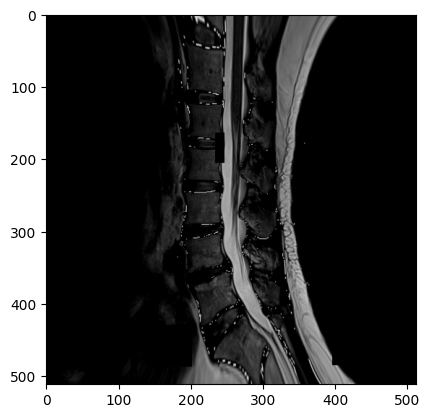


(512, 512, 5)
(512, 512, 10)
(512, 512, 10)
torch.Size([1, 5, 512, 512])


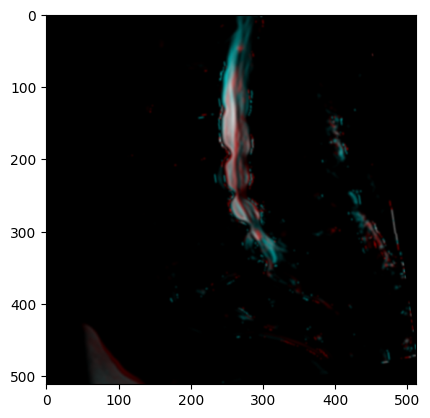


(512, 512, 5)
(512, 512, 10)
(512, 512, 10)
torch.Size([1, 5, 512, 512])


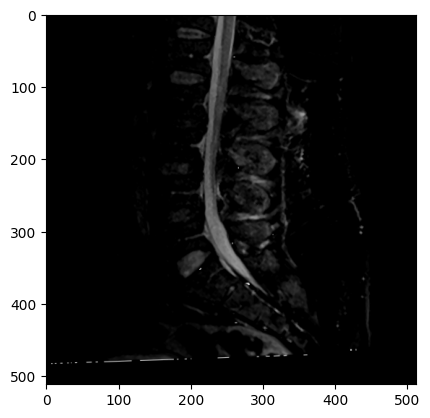


(512, 512, 5)
(512, 512, 10)
(512, 512, 10)
torch.Size([1, 5, 512, 512])


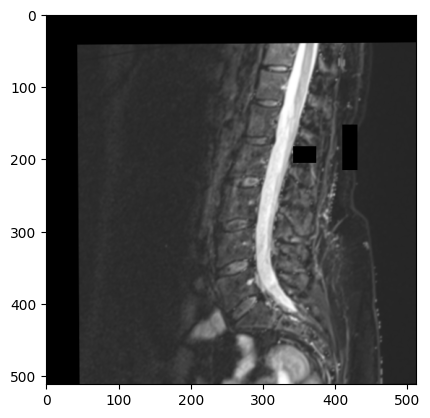


(512, 512, 5)
(512, 512, 10)
(512, 512, 10)
torch.Size([1, 5, 512, 512])


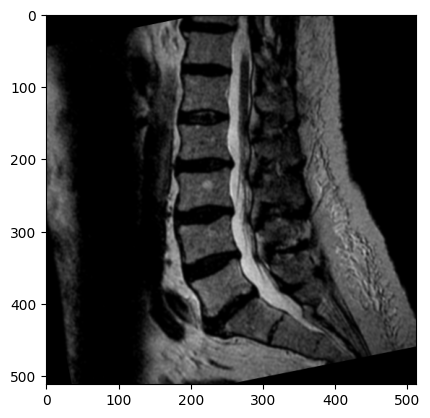


(512, 512, 5)
(512, 512, 10)
(512, 512, 10)


In [174]:
tmp_ds = RSNA24Dataset(train_df,result, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
            num_workers=0
            )

for i, (x, t) in enumerate(tmp_dl):
    if i==5:break
    x1,t1,x2,t2,x3,t3 = x    
    
    #print('x stat:', x2.shape, x2.min(), x2.max(),x2.mean(), x2.std())
    #print('x stat:', x1.shape, x1.min(), x3.max(),x1.mean(), x1.std())
    #print('x stat:', x3.shape, x3.min(), x3.max(),x3.mean(), x3.std())
    #print(t, t.shape)
    print(x1.shape)
    y = x1.numpy().transpose(0,2,3,1)[0,...,:3]
    y = (y + 1) / 2
    plt.imshow(y)
    plt.show()
    #print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()
plt.close()

In [28]:
grouped_counts = train_label_cordi.groupby('study_id').size().reset_index(name='Counts')

In [29]:
missingCords = grouped_counts[grouped_counts['Counts'] < 25]

In [30]:
pd.set_option('display.max_rows', 30)

In [31]:
missingCords

,study_id,Counts
16,46494080,21
24,64092030,21
30,74782131,22
43,97086905,23
73,159721286,21
...,...,...
1904,4140710202,23
1910,4146959702,22
1924,4175603528,23
1949,4232806580,19


In [ ]:
missing_cord_cordinates = train_label_cordi[train_label_cordi['study_id'].isin(missingCords['study_id'].values)]

In [ ]:
series_grouped_counts = missing_cord_cordinates.groupby('series_id').agg(
    study_id=('study_id', 'first'),  # example: take the first value of 'column1' in each group
    series_Counts=('series_id', 'size'),
    series_id=('series_id', 'first')
).reset_index(drop=True)

In [ ]:
series_grouped_counts = missing_cord_cordinates.groupby('series_id').size().reset_index(name='series_Counts')

In [ ]:
sorted_series_grouped_counts = series_grouped_counts.sort_values(by='study_id')

In [ ]:
sorted_series_grouped_counts

In [ ]:
missing_cord_des = train_series_description[train_series_description['series_id'].isin(sorted_series_grouped_counts['series_id'].values)]

In [ ]:
missing_cord_des

In [ ]:
merged_desc_df = pd.merge(sorted_series_grouped_counts, missing_cord_des, on=['study_id', 'series_id'], how='inner')

In [ ]:
merged_desc_df

In [ ]:
merged_desc_df[(merged_desc_df['series_description'] == 'Sagittal T2/STIR') & (merged_desc_df['series_Counts'] < 5) ]

In [ ]:
conditions = {
    'Sagittal T1': 10,
    'Axial T2': 10,
    'Sagittal T2/STIR': 5
}

# Initialize lists to store results
categories = []
meets_condition_counts = []
does_not_meet_condition_counts = []

# Iterate over the conditions and count the rows meeting and not meeting each condition
for category, threshold in conditions.items():
    meets_condition = merged_desc_df[(merged_desc_df['series_description'] == category) & (merged_desc_df['series_Counts'] < threshold)].shape[0]
    does_not_meet_condition = merged_desc_df[(merged_desc_df['series_description'] == category) & (merged_desc_df['series_Counts'] >= threshold)].shape[0]
    
    categories.append(category)
    meets_condition_counts.append(meets_condition)
    does_not_meet_condition_counts.append(does_not_meet_condition)

# Create a result DataFrame
result_df = pd.DataFrame({
    'Category': categories,
    'Meets Condition': meets_condition_counts,
    'Does Not Meet Condition': does_not_meet_condition_counts
})

In [ ]:
result_df

In [ ]:
train_df[train_df['study_id']== 4232806580 ]

In [ ]:
train_label_cordi[(train_label_cordi['instance_number'] != 8)  & (train_label_cordi['condition'] == 'Spinal Canal Stenosis') ]

In [ ]:
train_label_cordi[(train_label_cordi['study_id'] == 4232806580) ]

In [ ]:
import os

In [ ]:
files = os.listdir('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/46494080/1543341132')

In [ ]:
files

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pydicom as dicom
import pydicom

In [ ]:
import glob
from matplotlib import animation, rc

rc('animation', html='jshtml')

def load_dicom(filename):
    ds = pydicom.dcmread(filename)
    return ds.pixel_array

def load_dicom_line(path):
    t_paths = sorted(
        glob.glob(os.path.join(path, "*")), 
        key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split("-")[-1]),
    )
    images = []
    for filename in t_paths:
        data = load_dicom(filename)
        if data.max() == 0:
            continue
        images.append(data)
    return images

def create_animation(ims):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000//24)

path_to_folder = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4232806580/3008065164"
images = load_dicom_line(path_to_folder)
anim = create_animation(images)
anim